# QOD Mortality Prediction in the Intensive Care Unit
BME590 Final Project

Abbi Helfer, Arnold Tao, Ergang Wang, Chris Zhou
*** 

## Overview and Background

The intensive care unit (ICU) of a hospital interacts directly with severely ill patients and accordingly, has the highest mortality rate of any other hospital unit with about 500,000 deaths annually or 8-19% of admitted patients. Further, the high risk nature and complexity of cases amongst ICU patients have also made it the most likely hospital site for medical errors to occur. Thus, the ability to accurately predict patient mortality in these high-risk environments is especially crucial in ICUs where the value of repeated treatments, new interventions, and devoted medical resources is weighed against the likelihood of death. This foresight would allow hospitals to effectively triage patient treatments and distribute health resources accordingly to maximize the number of lives that can be saved. 

To that end, many researchers have turned towards machine learning based approaches that are able to harness the data-rich ICU environment to generate clinical risk scores and predictive models that make data-driven decisions for quantifying patient health and predicting future clinical outcomes. Widely used approaches have involved the generation of metrics like SAPS and APACHE, which are generally overestimated, or logistic regression models that rely on linear and additive relationships between predictor and outcome. More recent attempts to tackle this problem have involved the use of nonparametric algorithms that do not assume underlying distributions between predictor and outcome, or tree-based algorithms that are more adept at processing non-linear relationships. Unfortunately, many of the models that have been generated are designed to assess the quality of ICUs in aggregate, they are not finely calibrated enough to be used at the individual level. 

Despite key progress in the machine learning field, the development of new, more accurate machine learning models for predicting ICU mortality remain held back by scalability and number of available features. It is widely held in the machine learning field that 80% of the effort in model generation is devoted towards preparing the datasets before any analysis is even performed, which severely limits the number of custom datasets that can be used to generate predicted outcomes. In addition, the shear amount of data generated from a single ICU visit may result in hundreds or thousands of potential predictive variables which must be sorted through. Here, we utilized the MIMIC-III database (Medical Information Mart for Intensive Care III) which consists of deidentified data from more than 40,000 patients that were admitted to the critical care units of the Beth Israel Deaconess Medical Center. The use of this open-access database allows for reproducibility between researchers. Furthermore, the data has already been extracted from the EHR software, cutting back on the amount of time required to pre-process the data.


We aimed to develop a model that would be capable of predicting individual patient mortality in the ICU. Our model uses 48 hours’ worth of data collected from a patient to predict if the patient will die in the next 48 hours. No new data needs to be collected for a patient, existing data collected during an ICU stay is sufficient to make a prediction. This model could be applied every other day and utilized to make care decisions for the patient.

***

## Data

_How you extracted, cleaned, and transformed the data to answer the question_

Code detailing how data was extracted is available in the "Data Extraction" Jupyter notebook

From the MIMIC-III database we utilized the patient, admissions, chart events, output events, and lab events tables. 

We only included admission events that met the following criteria:
* Patient was 16 years of age or older
* Admission to ICU was longer than 4 hours 
* Admission was shorter than 21 days for patients that did not die in the ICU

Our final dataset consisted of 32,914 patients and 41,631 total admissions. We included admissions from patients with multiple visits to the ICU. The admissions dataset used for our models had the following demographics:

| Demographic     | Value           |
| -------------   | --------------- | 
| Age (years)     | 62.92 +/- 16.44 | 
| Male            |   57.1%         | 
| Ethnicity - White            |   70.4%         | 
| Ethnicity - Black            |   9.2%         | 
| Length of Stay (days)  |8.1 +/- 6.64        | 
| Died in ICU  |10.8%        | 
| Emergency Admission  |81.5%        | 
| Elective Admission  |16.1%        | 
| Urgent Admission  |2.4%        | 


### Feature Table Generation

In order to generate a feature table for modeling, we pulled select features from the following tables:

**Admissions table**
* Length of stay was calculated from the admit and discharge times
* Whether the patient died during the admission (HOSPITAL_EXPIRE_FLAG)

**Patients table**
* Gender
* Insurance
* Ethnicity 

**Lab Events**
* Abnormal lab values that occured more than 5 times in the dataset
* Minimum, maximum, and mean of Hematocrit, Potassium, Sodium, Creatinine, Chloride, Platelets, White Blood Cell, Hemoglobin, Glucose, RBC count

**Chart Events**
* Minimum, maximum, and mean of heart rate, oxygen, respiratory rate, systolic blood pressure, diastolic blood pressure, mean blood pressure, Glascow coma scores, temperature (F)

**Output Events**
* Sum of urine output

**Diagnoses ICD**
* Number of diagnoses for each patient

**Prescriptions**
* Number of medications for each patient

Overall, we started with a total of 336 features

### Splitting the data into 48 hour windows

Our goal was to predict whether the patient would die in the next 48 hours by using data from the past 48 hours. Therefore, the admisssions data had to be split into 48 hour windows. Each patients stay was split into unique events that encompasssed 48 hours of data. If a patient died during the 48 hours following the window, it was considered a death event. If a patient died during the 48 hour window it was excluded. Each window was assigned a unique identifier consisting of the HADM_ID and a bin number

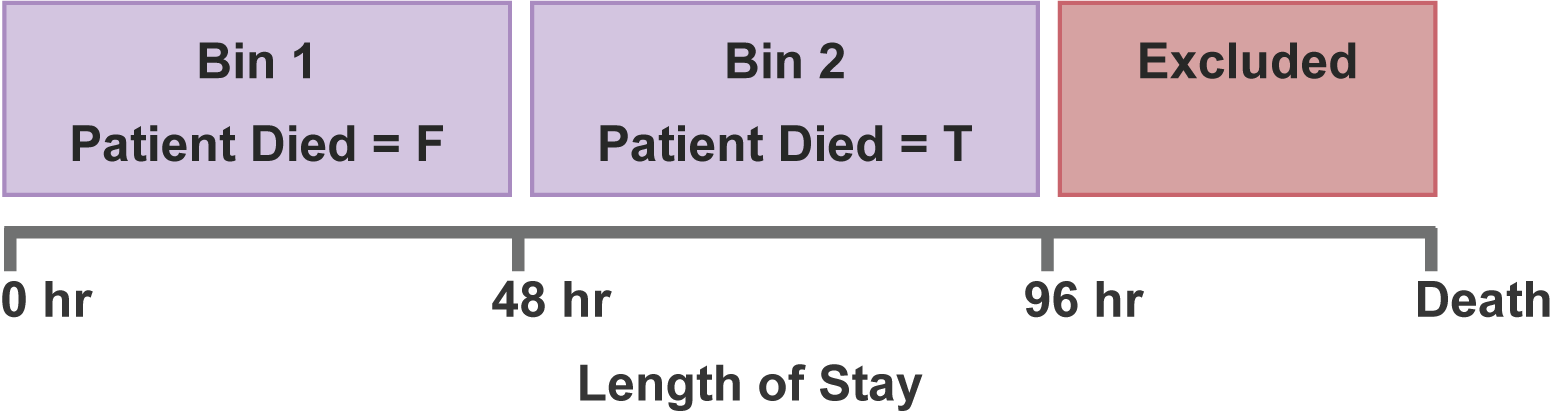

In [22]:
Image(filename= "../images/Data_windowing.png", width=500)

### Handling missing data
If data was missing from an admission window, we filled in missing values with the mean of the dataset ????
*** 

## Exploratory Data Analysis

_Explain the different ways that you looked at the data to understand the data better. Provide visualizations that help to present the data in a way that is compelling_

In order to better understand the features we extracted, we generated some data visualizations of key features. All code utilized to generate these visualizations can be found in the "Data_Explore.ipynb" jupyter notebook.

In [29]:
from IPython.display import Image
from IPython.core.display import HTML 

One interesting feature to look at is age. We see that the dead patients tend to be slightly older than patients that survive their ICU stay.

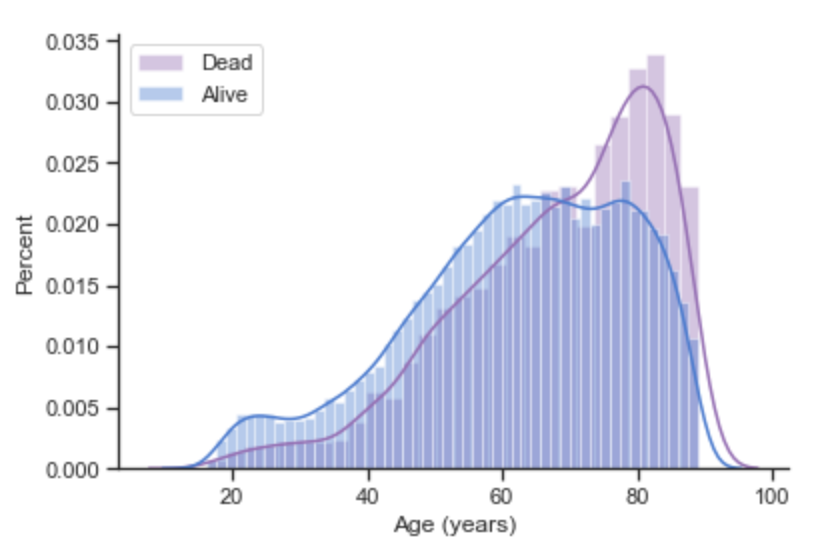

In [26]:
Image(filename= "../images/ages_live_dead.png", width=500)

We also looked at how long each patient stayed in the ICU. The length of stay peaked around 2-5 days for both alive and dead patients.

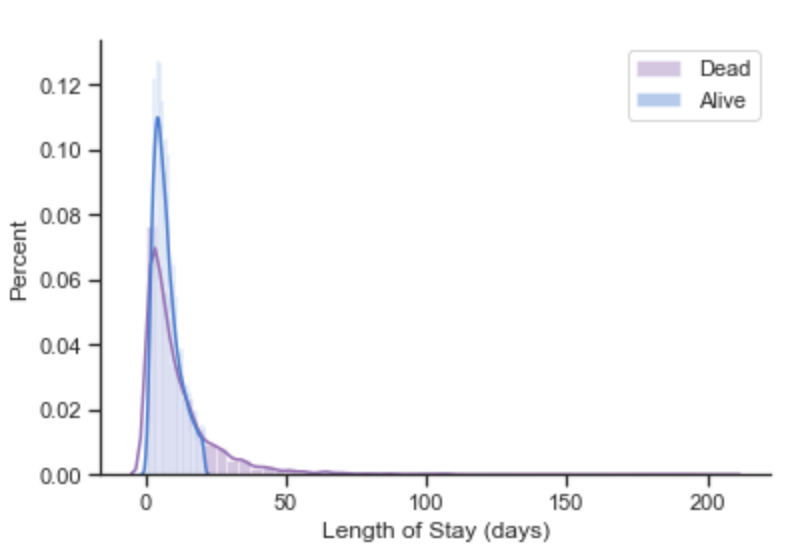

In [27]:
Image(filename= "../images/Len_of_stay_live_dead.png", width=500)

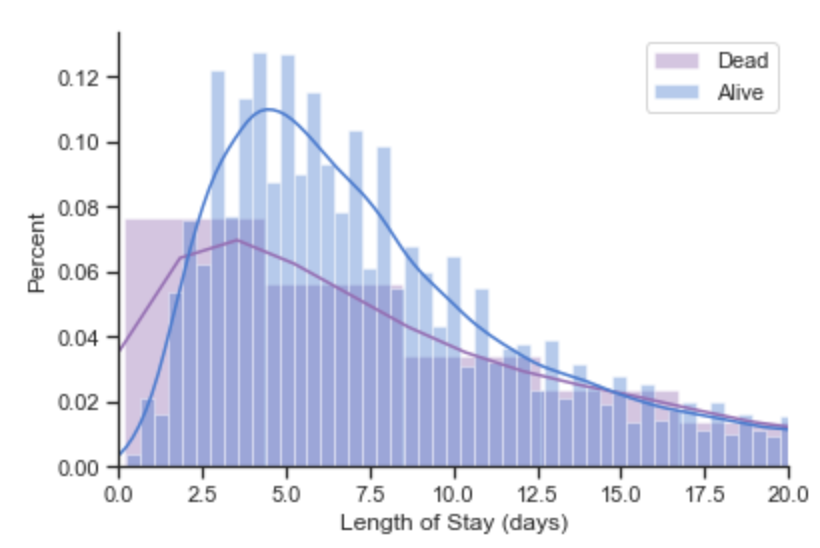

In [28]:
Image(filename= "../images/Len_of_stay_live_dead_zoom.png", width=500)

Looking at the gender distribution of our admissions we see that there are are more male patients admited to the ICU than females but a similar number of females and males die.

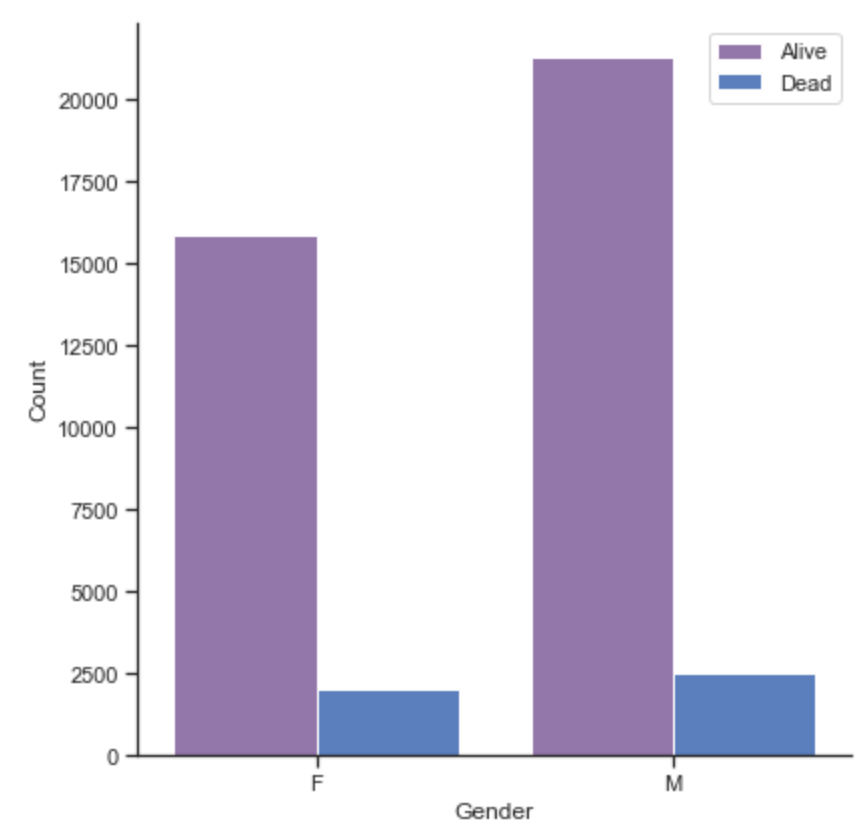

In [40]:
Image(filename= "../images/gender.png", width=400)

Sorting the patients by admission type reveals that most of the patients, live or dead, were admitted as an emergency admission.

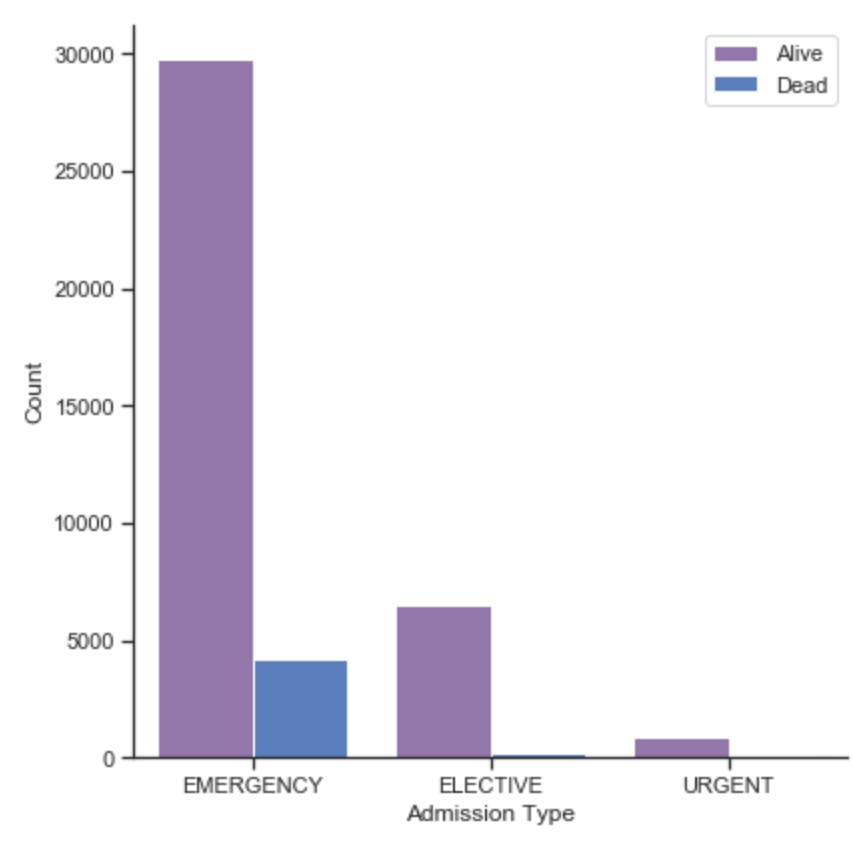

In [39]:
Image(filename= "../images/admission_type.png", width=400)

We looked into a few of the values that are collected for patients. We see that patients that died during their stay had lower oxygen saturation minimums, higher maximum temperatures, and higher mean heart rates. These trends make sense clinically as lower oxygen saturations, higher temperatures, and higher heart rates can be signs of a declining patient.

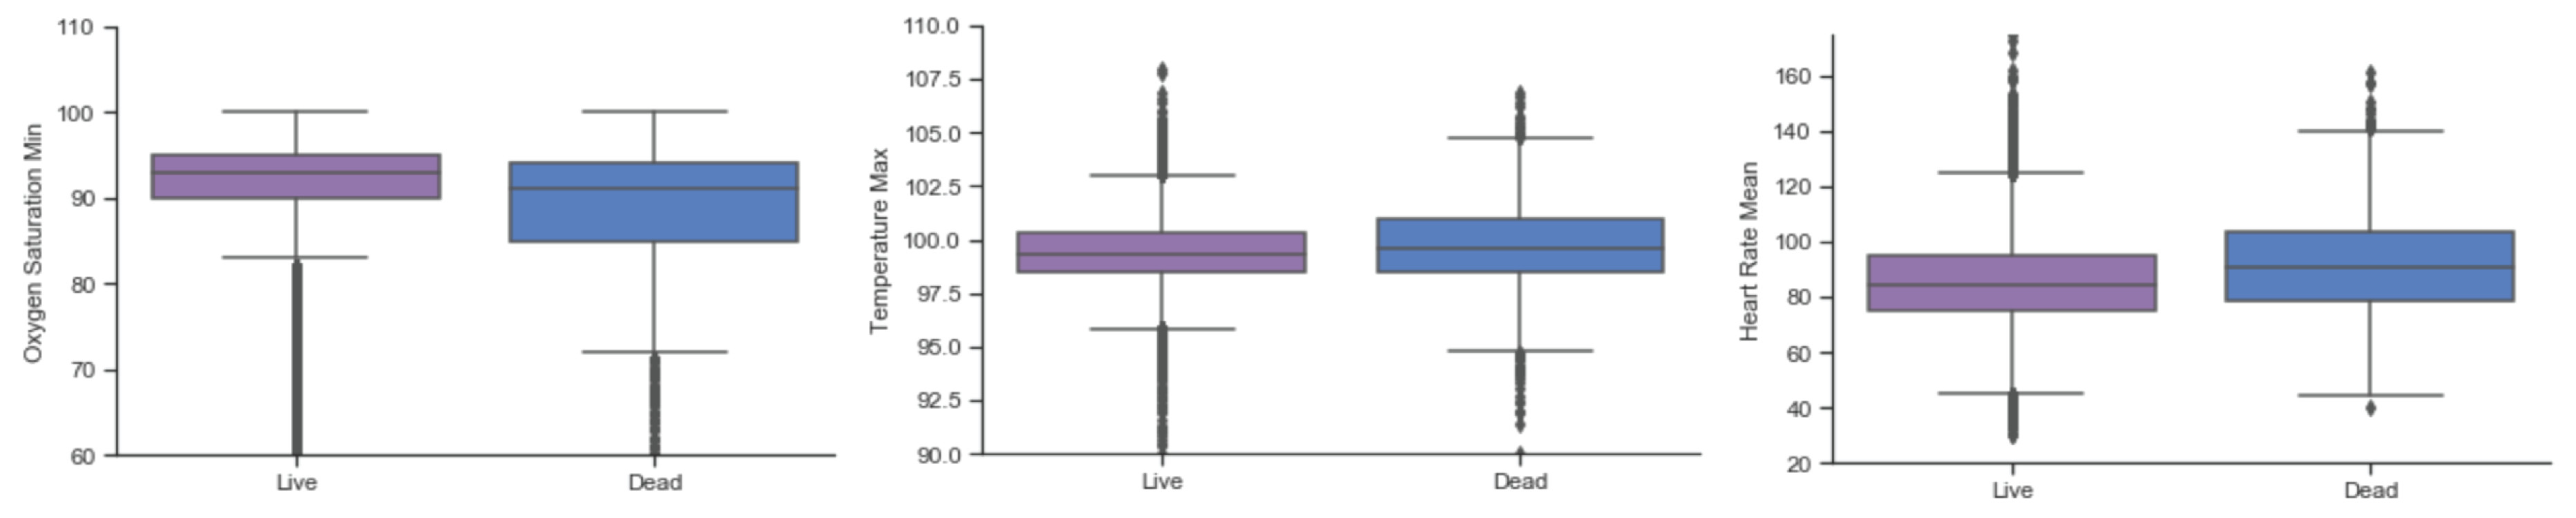

In [32]:
Image(filename= "../images/patient_features.png", width=1000)

We also looked into the Glascow Coma Scores of the patients. Lower values on the Glascow Coma Score indicate less responsiveness of the patient and a worse prognosis. Accordingly, we see that dead patients have lower Glascow Coma Score minimums than patients that lived.

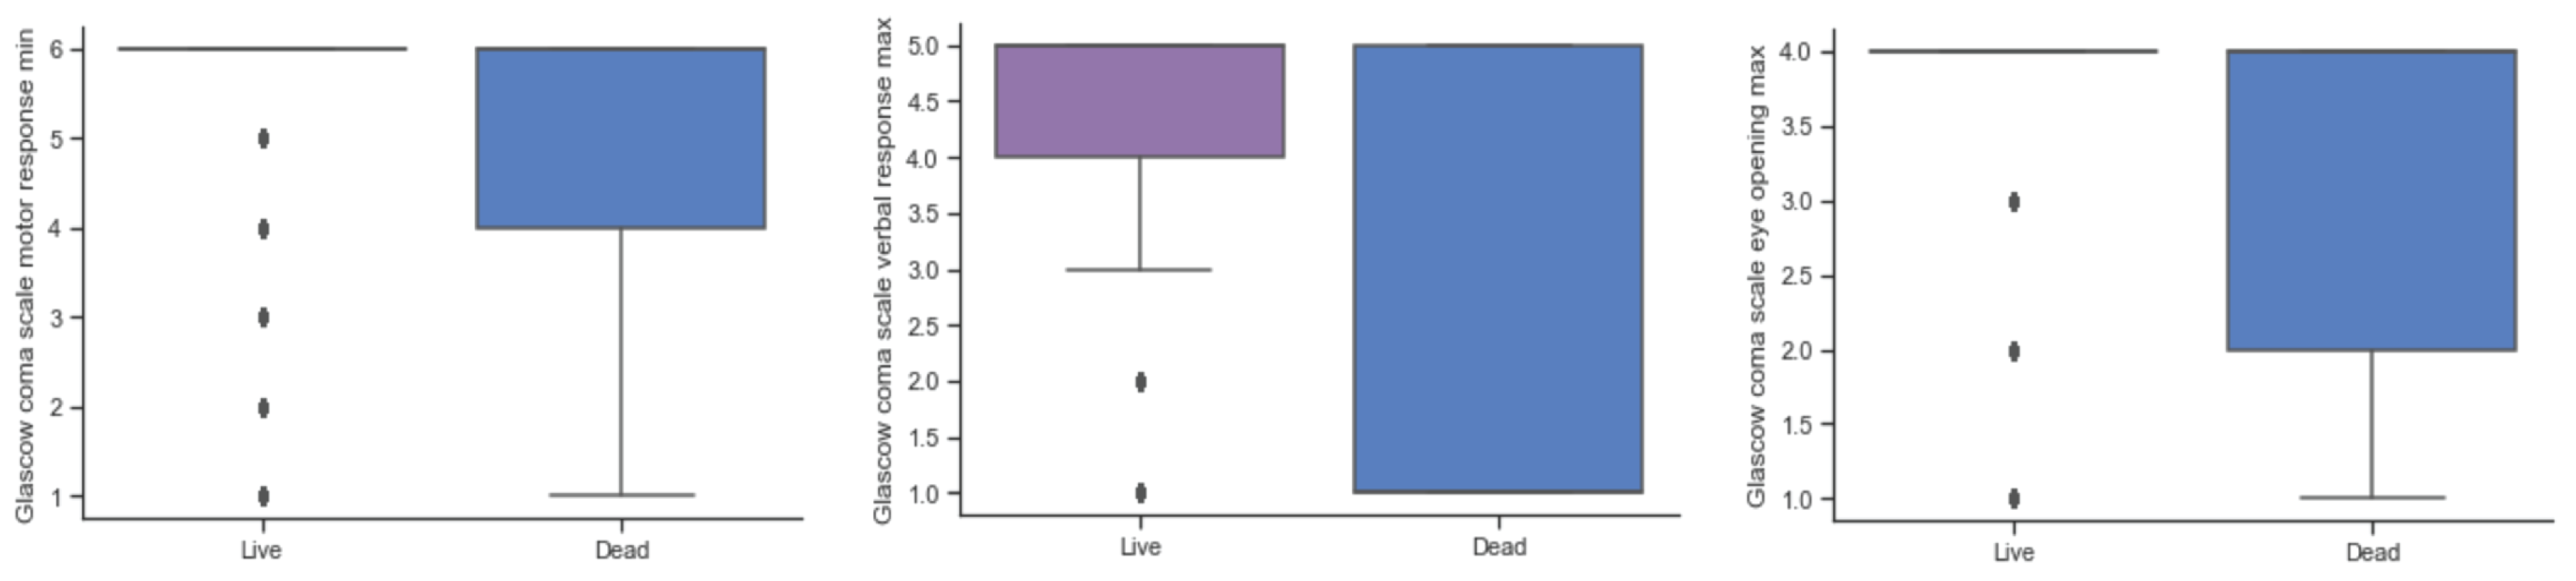

In [33]:
Image(filename= "../images/GCS.png", width=1000)

Overall, we see that some of the features may have some predictive value. However, due to the number of features we need to more systematically select the features that have the most value.

***

## Modeling

_Explain how you set up the modeling problem, which models you tried, how you set up parameter tuning, and what your results/metrics were_

***

## Suggestions

_If the model performed well, how would you implement it to solve a problem? If it does not perform well enough, explain why you think that is._

In the future we would like to compare the performance of our model to that of existing prediction systems (SAPS, APACHE) with the hope that our model can outperform currently utilized systems at the individual patient level. 

***

## References

1. https://healthpolicy.ucsf.edu/icu-outcomes
2. Wu AW, Pronovost P, Morlock L. ICU incident reporting systems. J Crit Care. Jun 2002;17(2):86-94.
3. Cullen DJ, Sweitzer BJ, Bates DW, Burdick E, Edmondson A, Leape LL. Preventable adverse drug events in hospitalized patients: a comparative study of intensive care and general care units. Crit Care Med. Aug 1997;25(8):1289-1297
4. Pirracchio, R. Mortality Prediction in the ICU Based on MIMIC-II Results from the Super ICU Learner Algorithm (SICULA) Project BT  - Secondary Analysis of Electronic Health Records. in (ed. Data, M. I. T. C.) 295–313 (Springer International Publishing, 2016). doi:10.1007/978-3-319-43742-2_20
5. Rajkomar, A. et al. Scalable and accurate deep learning with electronic health records. npj Digit. Med. 1–10 (2018). doi:10.1038/s41746-018-0029-1
6. Knaus, W.A., APACHE 1978-2001: the development of a quality assurance system based on prognosis: milestones and personal reflections. Arch Surg, 2002. 137(1): p. 37-41.